
# Intrinisc alignments power spectra using the halo model

This example showcases how to use the halo model for intrinsic alignment within CCL to compute GI and II contributions to the shear-shear power spectrum.


In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm


Preliminaries

First we generate the cosmology, the wavenumber
and scale factor arrays. The arrays are used for computing the power spectrum, $P(k,a)$

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

k_arr = np.geomspace(1E-3, 1e3, 128)  # For evaluating
lk_arr = np.log(k_arr)
a_arr = np.linspace(0.1, 1, 16)



We also need to initialize halo model quantities. These are:

    A halo mass definition.
    A concentration-mass relation.
    A halo mass function.
    A halo bias function.
    A halo model calculator object that will take care of the various integrals.



In [3]:


# Here we use a mass definition with Delta = 200 times the matter density,
hm_def = '200m'
# the Duffy 2008 concentration-mass relation,
cM = ccl.halos.ConcentrationDuffy08(mass_def=hm_def)
# the Tinker 2010 halo mass function,
nM = ccl.halos.MassFuncTinker10(mass_def=hm_def)
# the Tinker 2010 halo bias,
bM = ccl.halos.HaloBiasTinker10(mass_def=hm_def)

# and the halo model calculator object.
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=hm_def)



For this halo model, which is based on Fortuna et al. (2021, https://arxiv.org/abs/2003.02700), we will need a halo mass profile (taken to be an NFW) and a satellite intrinsic ellipticity/shear profile
. Power spectra can then be computed by taking the Fourier transform of these profiles. To do this in CCL, we generate a satellite shear HOD:

In [4]:
sat_gamma_HOD = ccl.halos.SatelliteShearHOD(concentration=cM, mass_def=hm_def, a1h=0.001, b=-2)

Satellite intrinsic shear profile

The real part of the satellite intrinsic shear profile is determined by
which is taken to be
while also imposing that
. The parameters a1h and b are inputs to the satellite shear HOD above, together with a concentration-mass relation. For a constant mean intrinsic shear
, one can set b=0 and the a1h parameter will determine

.

To obtain the Fourier transform of the profile,
, the FFTLog method will be used by default. Other methods are available but slower. The FFTLog parameters have been set internally to produce fast and accurate results, but can be further tweaked with the sat_gamma_HOD.update_precision_fftlog function. The real-space and Fourier-space intrinsic shear profiles at redshift 0 for a halo with
M
look like this:

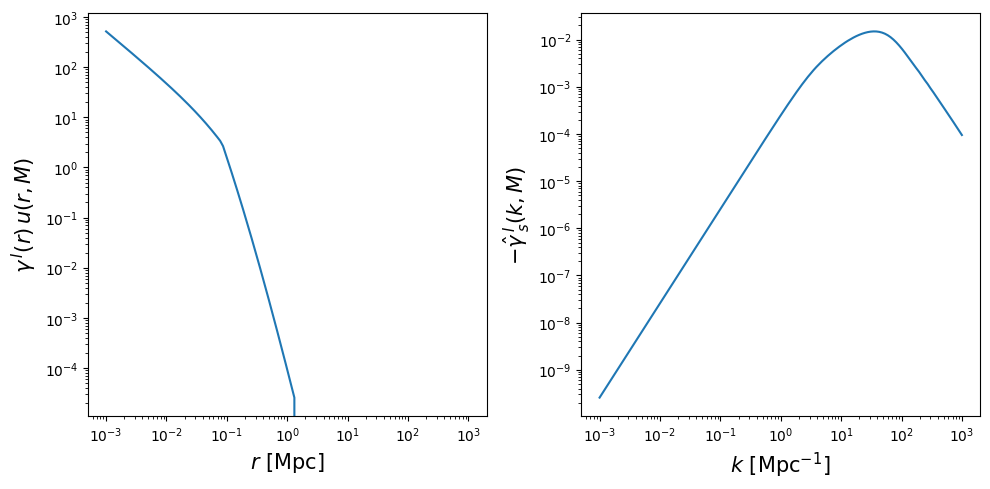

In [5]:


Mhalo = 1e14 # Msun.
a_eval = 1. # Redshift 0.

gamma_r = sat_gamma_HOD._real(cosmo, k_arr, Mhalo, a_eval)
gamma_k = sat_gamma_HOD._usat_fourier(cosmo, k_arr, Mhalo, a_eval)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(k_arr, gamma_r)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$\gamma\,^I(r)\,u(r,M)\,$', fontsize=15)
ax[0].set_xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15)

ax[1].plot(k_arr, -gamma_k)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$-\hat{\gamma}\,_s^I(k, M)\,\,$', fontsize=15)
ax[1].set_xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15)
fig.tight_layout()
plt.show()



Power spectra

The satellite intrinsic shear HOD profile easily allows for the computation of the 1-halo and 2-halo satellite contributions to the GI and II power spectra. The 2-halo central contribution is given by the linear alignment model and the 2-halo central-satellite II contribution is a little more involved. It is given by
where the integral can be computed with the pyccl.halos.halomod_bias_1pt function.

In [6]:


# Compute the II Power spectra
pk_II_1h_ss = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, get_2h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_II_2h_ss = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, get_1h=False, a_arr=a_arr, lk_arr=lk_arr)

# Compute here the 2-halo c-s term:
A_IA = 1
C1rhocrit = 0.0134
C = A_IA * C1rhocrit * cosmo['Omega_m'] / cosmo.growth_factor(a_arr)
C_pk_lin = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                         pk_arr=C.reshape(-1,1)*cosmo.linear_matter_power(np.e**lk_arr, a_arr),
                         is_logp=False)
pk_b_gamma = -1 * ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                pk_arr=ccl.halos.halomod_bias_1pt(cosmo, hmc, np.e**lk_arr, a_arr,
                                                                  sat_gamma_HOD), is_logp=False)
pk_II_2h_cs = C_pk_lin * pk_b_gamma

pk_II_2h_cc = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                            pk_arr=C.reshape(-1,1)**2*cosmo.linear_matter_power(np.e**lk_arr, a_arr),
                            is_logp=False)
pk_II_total = pk_II_1h_ss + pk_II_2h_ss + pk_II_2h_cs + pk_II_2h_cc




Galaxy position - shape power spectra

Using the HOD capabilities of CCL, we can also compute the correlation between galaxy positions and shapes with the halo model. This is done below.


In [7]:
# Compute below the GI power spectra
# NFW profile for matter (G)
NFW =  ccl.halos.HaloProfileNFW(mass_def=hm_def, concentration=cM, truncated=True, fourier_analytic=True)

pk_GI_1h_s = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW, prof2 = sat_gamma_HOD, get_2h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_GI_2h_s = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW, prof2 = sat_gamma_HOD, get_1h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_GI_2h_c = -1*C_pk_lin
pk_GI_total = pk_GI_1h_s + pk_GI_2h_s + pk_GI_2h_c

In [8]:
pk_II_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr, pk_arr=C.reshape(-1,1)**2*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr), is_logp=False)
pk_GI_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr, pk_arr=-C.reshape(-1,1)*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr), is_logp=False)

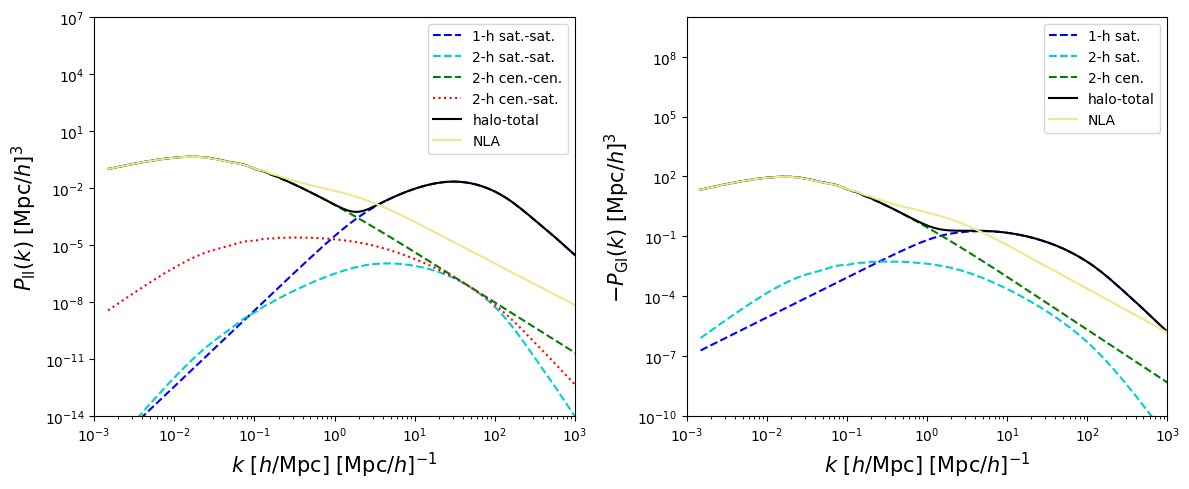

In [9]:


fig, ax = plt.subplots(1, 2, figsize=(12,5))
a_eval = 1/(1+0.11)
ax[0].loglog(k_arr/cosmo['h'], pk_II_1h_ss(k_arr, a_eval)*cosmo['h']**3, label='1-h sat.-sat.', c='blue', ls='--')
ax[0].loglog(k_arr/cosmo['h'], pk_II_2h_ss(k_arr, a_eval)*cosmo['h']**3, label='2-h sat.-sat.', c='darkturquoise', ls='--')
ax[0].loglog(k_arr/cosmo['h'], pk_II_2h_cc(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-cen.', c='g', ls='--')
ax[0].loglog(k_arr/cosmo['h'], pk_II_2h_cs(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-sat.', c='r', ls=':')
ax[0].loglog(k_arr/cosmo['h'], pk_II_total(k_arr, a_eval)*cosmo['h']**3, label='halo-total', c='k')
ax[0].loglog(k_arr/cosmo['h'], pk_II_NLA(k_arr, a_eval)*cosmo['h']**3, label='NLA', c='khaki')
ax[0].set_ylabel(r'$P_{\mathrm{II}}(k)$ [Mpc$/h$]$^3$', fontsize=15)
ax[0].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$ [Mpc$/h$]$^{-1}$', fontsize=15)
ax[0].legend()
ax[0].set_xlim([1e-3, 1e3])
ax[0].set_ylim([1e-14, 1e7])

ax[1].loglog(k_arr/cosmo['h'], -pk_GI_1h_s(k_arr, a_eval)*cosmo['h']**3, label='1-h sat.', c='blue', ls='--')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_2h_s(k_arr, a_eval)*cosmo['h']**3, label='2-h sat.', c='darkturquoise', ls='--')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_2h_c(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.', c='g', ls='--')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_total(k_arr, a_eval)*cosmo['h']**3, label='halo-total', c='k')
ax[1].loglog(k_arr/cosmo['h'], -pk_GI_NLA(k_arr, a_eval)*cosmo['h']**3, label='NLA', c='khaki')
ax[1].set_ylabel(r'$-P_{\mathrm{GI}}(k)$ [Mpc$/h$]$^3$', fontsize=15)
ax[1].set_xlabel(r'$k\,\,[h/{\rm Mpc}]$ [Mpc$/h$]$^{-1}$', fontsize=15)
ax[1].legend()
ax[1].set_xlim([1e-3, 1e3])
ax[1].set_ylim([1e-10, 1e10])

fig.tight_layout()
plt.show()



In [10]:
# We first need a galaxy HOD
galaxyHOD = ccl.halos.HaloProfileHOD(concentration=cM, mass_def=hm_def)

# First we will try computing the cross-correaltion of the sattelite shear HOD and the galaxy HOD
pk_gI_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, prof2=galaxyHOD, get_2h = False, a_arr=a_arr, lk_arr=lk_arr)
pk_gI_2h_cs = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD, prof2=galaxyHOD, get_1h = False, a_arr=a_arr, lk_arr=lk_arr)
b_g = 1. # Setting galaxy bias to 1 for illustration.
pk_gI_2h_cc = -1 * b_g * C_pk_lin

pk_gI_total = pk_gI_1h + pk_gI_2h_cs + pk_gI_2h_cc

# The NLA prediction:
pk_gI_NLA = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr, pk_arr=-C.reshape(-1,1)*b_g*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr), is_logp=False)


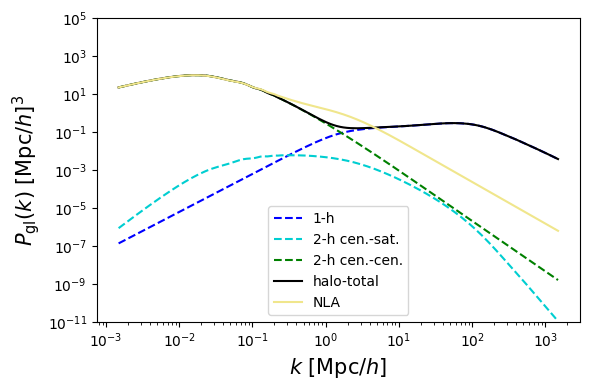

In [11]:


fig, ax = plt.subplots(1, figsize=(6,4))

ax.plot(k_arr/cosmo['h'], -pk_gI_1h(k_arr, a_eval)*cosmo['h']**3, label='1-h', c='blue', ls='--')
ax.plot(k_arr/cosmo['h'], -pk_gI_2h_cs(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-sat.', c='darkturquoise', ls='--')
ax.plot(k_arr/cosmo['h'], -pk_gI_2h_cc(k_arr, a_eval)*cosmo['h']**3, label='2-h cen.-cen.', c='green', ls='--')
ax.plot(k_arr/cosmo['h'], -pk_gI_total(k_arr, a_eval)*cosmo['h']**3, label='halo-total', c='black', ls='-')
ax.plot(k_arr/cosmo['h'], -pk_gI_NLA(k_arr, a_eval)*cosmo['h']**3, label='NLA', c='khaki', ls='-')
ax.set_ylabel(r'$P_{\mathrm{gI}}(k)$ [Mpc$/h$]$^3$', fontsize=15)
ax.set_xlabel(r'$k$ [Mpc$/h$]', fontsize=15)
ax.legend()

#a.set_xlim([1e-3, 1e3])
ax.set_ylim([1e-11, 1e5])
ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()
plt.show()



TypeError: NumberCountsTracer() missing 1 required keyword-only argument: 'has_rsd'

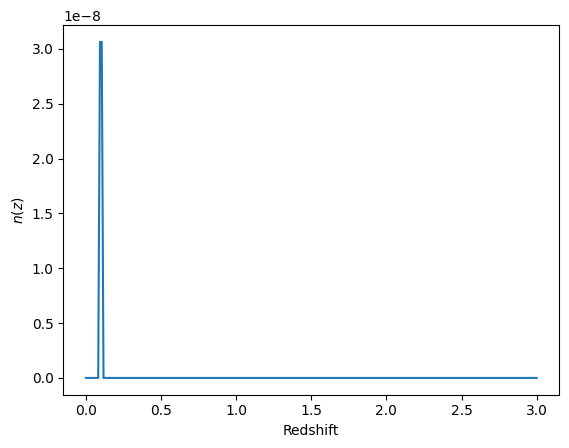

In [129]:
z_arr = np.linspace(0., 3., 256)
z0 = 0.1
pz = np.exp(-0.5 * ((z_arr - z0) / 0.001)**2)

plt.plot(z_arr, pz)
plt.xlabel('Redshift')
plt.ylabel('$n(z)$')

b_IA = np.ones(len(z_arr)) # A_IA = 1 in the NLA model
# A tracer without shear and A_ia contribution. The alignment signal is embedded in the power spectrum.
ia_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr, b_IA), use_A_ia=False)
# A tracer without shear but with A_ia, to plot the NLA-only contribution for comparison.
ia_NLA_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr, b_IA), use_A_ia=True)
# A weak gravitational lensing tracer for the GG and GI terms.
wl_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz))
g_tracer = ccl.NumberCountsTracer(cosmo,dndz = (z_arr, pz))

l_arr = np.unique(np.geomspace(2, 60000, 256).astype(int))

cl_GI = ccl.angular_cl(cosmo, g_tracer, ia_tracer, l_arr, p_of_k_a = pk_GI_total)
cl_II = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk_II_total)
cl_GI_NLA = ccl.angular_cl(cosmo, g_tracer, ia_NLA_tracer, l_arr)
cl_II_NLA = ccl.angular_cl(cosmo, ia_NLA_tracer, ia_NLA_tracer, l_arr)
cl_GG = ccl.angular_cl(cosmo, g_tracer, g_tracer, l_arr)

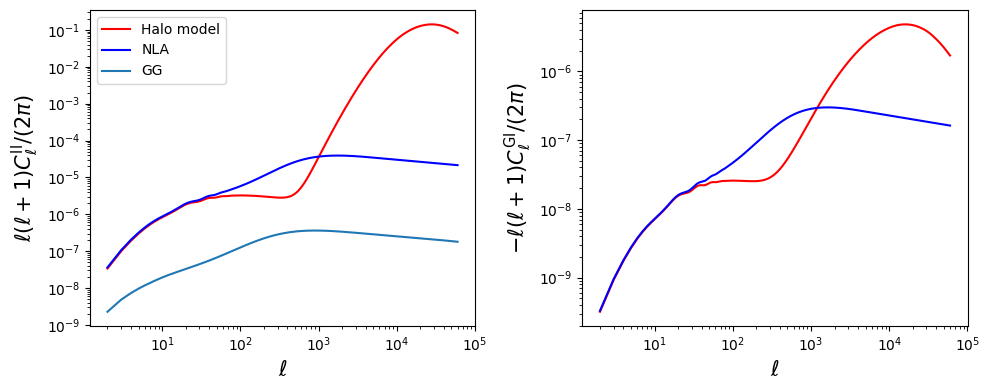

In [130]:


lfac = l_arr * (l_arr + 1) / (2 * np.pi)

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(l_arr, lfac * cl_II, label='Halo model', c='red')
ax[0].plot(l_arr, lfac * cl_II_NLA, label='NLA', c='blue')
ax[0].plot(l_arr, lfac * cl_GG, label='GG')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{\mathrm{II}}/(2\pi)$', fontsize=15)
ax[0].legend()

ax[1].plot(l_arr, -lfac * cl_GI, c='red')
ax[1].plot(l_arr, -lfac * cl_GI_NLA, c='blue')
ax[1].set_ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{GI}}/(2\pi)$', fontsize=15)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel(r'$\ell$', fontsize=15)

fig.tight_layout()
plt.show()



In [131]:


k1h = 4*cosmo['h'] #1/Mpc
k2h = 6*cosmo['h'] #1/Mpc

pk_II_NLA_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                   pk_arr=C.reshape(-1,1)**2*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr)*np.exp(-(k_arr/k2h)**2).reshape(1,-1),
                                   is_logp=False)
pk_GI_NLA_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                   pk_arr=-C.reshape(-1,1)*cosmo.nonlin_matter_power(np.e**lk_arr, a_arr)*np.exp(-(k_arr/k2h)**2).reshape(1,-1),
                                   is_logp=False)

pk_II_1h_ss_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                     pk_arr=pk_II_1h_ss(k_arr, a_arr)*(1-np.exp(-(k_arr/k1h)**2)).reshape(1,-1),
                                     is_logp=False)
pk_GI_1h_s_windowed = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=lk_arr,
                                     pk_arr=pk_GI_1h_s(k_arr, a_arr)*(1-np.exp(-(k_arr/k1h)**2)).reshape(1,-1),
                                     is_logp=False)
pk_II_windowed = pk_II_NLA_windowed+pk_II_1h_ss_windowed
pk_GI_windowed = pk_GI_NLA_windowed+pk_GI_1h_s_windowed



In [132]:


cl_GI_windowed = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a = pk_GI_windowed)
cl_II_windowed = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk_II_windowed)



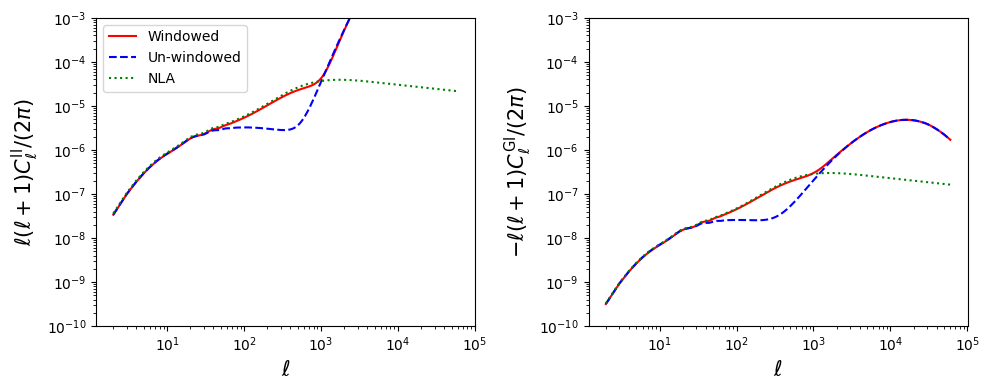

In [133]:


fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(l_arr, lfac * cl_II_windowed, label='Windowed', c='red')
ax[0].plot(l_arr, lfac * cl_II, label='Un-windowed', c='blue', ls='--')
ax[0].plot(l_arr, lfac * cl_II_NLA, label='NLA', c='green', ls='dotted')
ax[0].set_ylabel(r'$\ell(\ell+1)C_\ell^{\mathrm{II}}/(2\pi)$', fontsize=15)
ax[0].legend()

ax[1].plot(l_arr, -lfac * cl_GI_windowed, c='red')
ax[1].plot(l_arr, -lfac * cl_GI, label='Un-windowed', c='blue', ls='--')
ax[1].plot(l_arr, -lfac * cl_GI_NLA, label='NLA', c='green', ls='dotted')
ax[1].set_ylabel(r'$-\ell(\ell+1)C_\ell^{\mathrm{GI}}/(2\pi)$', fontsize=15)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_ylim([1e-10, 1e-3])
    a.set_xlabel(r'$\ell$', fontsize=15)

fig.tight_layout()
plt.show()



# Correlation functions

Below we also have a look at the
correlation function with the different angular power spectra we have computed

In [134]:
thetas = np.geomspace(1, 250, 40)
xip = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG+cl_GI+cl_II, theta=thetas/60, type='GG+')
xip_NLA = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG+cl_GI_NLA+cl_II_NLA, theta=thetas/60, type='GG+')
xip_windowed = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG+cl_GI_windowed+cl_II_windowed, theta=thetas/60, type='GG+')


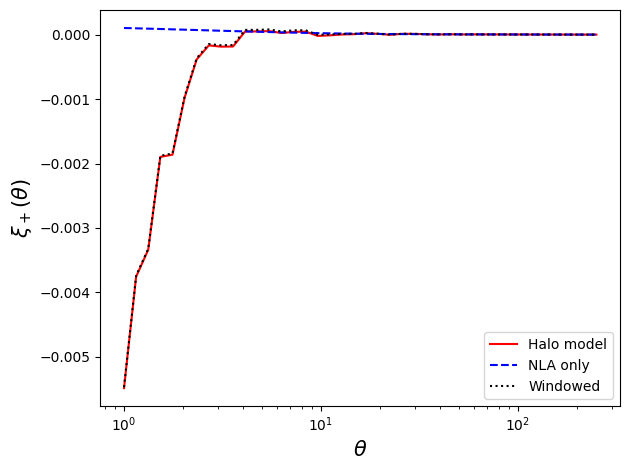

In [135]:


fig, ax = plt.subplots()

ax.plot(thetas, xip, label='Halo model', c='red')
ax.plot(thetas, xip_NLA, label='NLA only', c='blue', ls='--')
ax.plot(thetas, xip_windowed, label='Windowed', c='black', ls='dotted')
ax.set_ylabel(r'$\xi_+(\theta)$', fontsize=15)
ax.legend()

ax.set_xscale('log')
ax.set_xlabel(r'$\theta$', fontsize=15)

fig.tight_layout()
plt.show()



In [136]:


from wigner import wigner_dl
from scipy.interpolate import interp1d

def wigD_correlation(cosmo, l_arr,
                     tracer1, tracer2,
                     corr, theta,
                     p_of_k_a=None,
                     pm=1,
                     sampling=1e5,
                     show_prog=True):

    # set spin values based on correlation type provided
    if corr == 'NG':
        sa = 0
        sb = 2
    elif corr == 'GG':
        sa = 2
        sb = 2
    elif corr == 'NN':
        sa = 0
        sb = 0
    else:
        raise ValueError('Not a valid correlation type')
    # define a larger ell array for wigner matrix
    lmin = l_arr.min()
    lmax = int(lmin + sampling)
    ell_arr_sample = np.unique(np.geomspace(lmin, lmax, 1024).astype(int))
    # recompute angular cl
    Cl_sample = ccl.angular_cl(cosmo, tracer1, tracer2, ell_arr_sample, p_of_k_a=p_of_k_a)
    # interpolate to get high density array
    ell_arr  = np.arange(lmin, lmax)
    Cl_intp = interp1d(ell_arr_sample, Cl_sample)

    # loop over theta values and calculate xi at each
    xi = np.zeros_like(theta)
    for th in range(len(theta)):
        # get wigner-d matrix for given theta
        d_ell = wigner_dl(lmin, lmax, sa, sb, np.radians(theta[th]))
        # compute xi value for given theta by summing over ell values
        xi_temp = 0
        prefactor = (2*ell_arr + 1)/(4*np.pi)
        C_ab_l = pm**(sb) * Cl_intp(ell_arr)
        xi_temp += np.sum(prefactor * C_ab_l * d_ell[:-1])
        # record result to array
        xi[th] = xi_temp

    return xi



In [158]:


xip_wig_GI = wigD_correlation(cosmo, l_arr, g_tracer, ia_tracer, 'GG', thetas/60,
                              p_of_k_a=pk_GI_total, sampling=4e6)
xip_wig_II = wigD_correlation(cosmo, l_arr, g_tracer, ia_tracer, 'GG', thetas/60,
                              p_of_k_a=pk_II_total, sampling=4e6)
xip_GG = ccl.correlation(cosmo, ell=l_arr, C_ell=cl_GG, theta=thetas/60, type='GG+')
xip_tot = xip_GG+xip_wig_II+xip_wig_GI



NameError: name 'g_tracer' is not defined

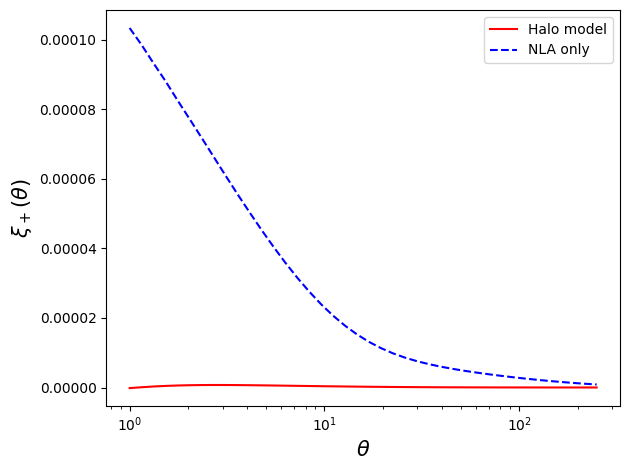

In [159]:


fig, ax = plt.subplots()

ax.plot(thetas, xip_tot, label='Halo model', c='red')
ax.plot(thetas, xip_NLA, label='NLA only', c='blue', ls='--')
ax.set_ylabel(r'$\xi_+(\theta)$', fontsize=15)
ax.legend()

ax.set_xscale('log')
ax.set_xlabel(r'$\theta$', fontsize=15)

fig.tight_layout()
plt.show()


In [160]:
   r"""
    Compute the 3D correlation function with linear RSDs using
    multipoles:

    .. math::
        \xi(r,\mu) = \sum_{\ell\in\{0,2,4\}}\xi_\ell(r)\,P_\ell(\mu)

    where :math:`P_\ell(\mu)` are the Legendre polynomials, and
    :math:`\xi_\ell(r)` are the correlation function multipoles.

    Args:
        cosmo (:class:`~pyccl.cosmology.Cosmology`): A Cosmology object.
        r (:obj:`float` or `array`): distance(s) at which to calculate the
            3D correlation function (in Mpc).
        a (:obj:`float`): scale factor.
        mu (:obj:`float`): cosine of the angle at which to calculate the 3D
            correlation function.
        beta (:obj:`float`): growth rate divided by galaxy bias.
        p_of_k_a (:class:`~pyccl.pk2d.Pk2D`, :obj:`str` or :obj:`None`): 3D Power spectrum
            to integrate. If a string, it must correspond to one of the
            non-linear power spectra stored in `cosmo` (e.g.
            `'delta_matter:delta_matter'`).
        use_spline (:obj:`bool`): switch that determines whether the RSD correlation
            function is calculated using global splines of multipoles.

    Returns:
        Value(s) of the correlation function at the input distance(s) & angle.
    """ # noqa

"\n Compute the 3D correlation function with linear RSDs using\n multipoles:\n\n .. math::\n     \\xi(r,\\mu) = \\sum_{\\ell\\in\\{0,2,4\\}}\\xi_\\ell(r)\\,P_\\ell(\\mu)\n\n where :math:`P_\\ell(\\mu)` are the Legendre polynomials, and\n :math:`\\xi_\\ell(r)` are the correlation function multipoles.\n\n Args:\n     cosmo (:class:`~pyccl.cosmology.Cosmology`): A Cosmology object.\n     r (:obj:`float` or `array`): distance(s) at which to calculate the\n         3D correlation function (in Mpc).\n     a (:obj:`float`): scale factor.\n     mu (:obj:`float`): cosine of the angle at which to calculate the 3D\n         correlation function.\n     beta (:obj:`float`): growth rate divided by galaxy bias.\n     p_of_k_a (:class:`~pyccl.pk2d.Pk2D`, :obj:`str` or :obj:`None`): 3D Power spectrum\n         to integrate. If a string, it must correspond to one of the\n         non-linear power spectra stored in `cosmo` (e.g.\n         `'delta_matter:delta_matter'`).\n     use_spline (:obj:`bool`): sw

In [161]:
# Define the range and number of bins for rpar
rpar_cents = np.linspace(-200, 200, 101 )  
rperp_cents = np.linspace(-200, 200, 101 )

In [162]:
r = np.sqrt( rpar_cents**2 + rperp_cents**2 )

In [163]:
mu = rpar_cents / r

/tmp/ipykernel_34512/2042851335.py:1: RuntimeWarning: invalid value encountered in divide
  mu = rpar_cents / r


In [164]:
x0 = ccl.correlation_3dRsd( cosmo , 
                       r = r , 
                       a = 1/(1+0.5) , 
                       mu = np.cos( np.pi / 2. ) , 
                       beta=0 , 
                       p_of_k_a = pk_GI_NLA , 
                       use_spline = False )

x1 = ccl.correlation_3dRsd( cosmo , 
                       r = r , 
                       a = 1/(1+0.5) , 
                       mu = np.cos( np.pi / 6. ) , 
                       beta=0 , 
                       p_of_k_a = pk_GI_NLA , 
                       use_spline = False )

In [165]:
h = 0.7

(50.0, 200.0)

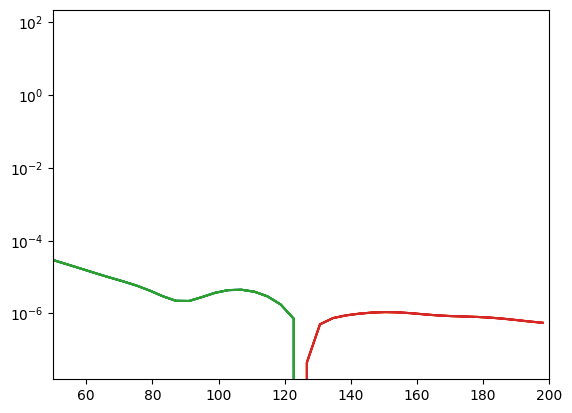

In [166]:
plt.plot( r * h ,  -x0 )
plt.plot( r * h ,  x0 )

plt.plot( r * h ,  -x1 )
plt.plot( r * h ,  x1 )

plt.yscale('log')
plt.xlim( 50 , 200)


(-0.2, 0.1)

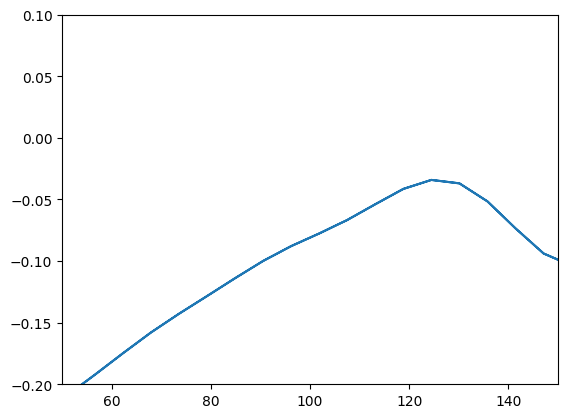

In [167]:
# plt.plot( r ,  -x )
plt.plot( r ,  x0 * r**2 )
plt.xlim( 50 , 150)
#plt.ylim( -1e-4  *100**2, 1e-4 *100**2 )
plt.ylim( -0.2 , 0.1 )

In [168]:
xi_gn_p_results = np.load('lrg_xi_gn_p_results.npy')
xi_gn_x_results = np.load('lrg_xi_gn_x_results.npy')

In [169]:
rpar_bins = np.linspace(-200, 200, 201 )  
rperp_bins = np.linspace( 0.5, 200, 101 )

In [170]:
r_perp_cents  = ( rperp_bins[1:] + rperp_bins[:-1] )/2.
r_par_cents = ( rpar_bins[1:] + rpar_bins[:-1] )/2.

# Flatten the xi_results and r_results arrays
xi_gn_p_flat = np.array(xi_gn_p_results).flatten()
xi_gn_x_flat = np.array(xi_gn_x_results).flatten()


r_perp_flat = np.array([r_perp_cents] * len(r_par_cents)).flatten()
r_par_flat = np.array([[r_par] * len(r_perp_cents) for r_par in r_par_cents]).flatten()

In [171]:
# Calculate s for each pair of (r_perp, r_par)
s = np.sqrt(r_perp_flat**2 + r_par_flat**2)

# Define bins for s
#s_bins = np.linspace(0.5, 200, 30 )
s_bins = np.logspace( np.log10( 0.1 ) , np.log10( 200 ) , 60 )
s_cents = (s_bins[1:] + s_bins[:-1]) / 2.

# Initialize arrays to store the results
xi_p_s = np.zeros(len(s_bins) - 1)
var_xi_p_s = np.zeros(len(s_bins) - 1)
counts_p = np.zeros(len(s_bins) - 1)

xi_x_s = np.zeros(len(s_bins) - 1)
var_xi_x_s = np.zeros(len(s_bins) - 1)
counts_x = np.zeros(len(s_bins) - 1)

# Calculate theta
theta = np.degrees(np.arctan2(r_par_flat, r_perp_flat))

# Bin the results by s and calculate the radial averages and variances
for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1])
    if np.any(mask):  # Check if there are any elements in the mask
        xi_p_s[i] = np.mean(xi_gn_p_flat[mask])
        var_xi_p_s[i] = np.var(xi_gn_p_flat[mask])
        counts_p[i] = np.sum(mask)

        xi_x_s[i] = np.mean(xi_gn_x_flat[mask])
        var_xi_x_s[i] = np.var(xi_gn_x_flat[mask])
        counts_x[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_p_s[counts_p == 0] = np.nan
var_xi_p_s[counts_p == 0] = np.nan

xi_x_s[counts_x == 0] = np.nan
var_xi_x_s[counts_x == 0] = np.nan

# Calculate the average within the specified theta ranges and r_perp >= 5
theta_mask = (((theta > -45) & (theta < 45)) | ((theta > 135) & (theta < 225))) & (r_perp_flat >= 5)

xi_p_s_theta = np.zeros(len(s_bins) - 1)
var_xi_p_s_theta = np.zeros(len(s_bins) - 1)
counts_p_theta = np.zeros(len(s_bins) - 1)

xi_x_s_theta = np.zeros(len(s_bins) - 1)
var_xi_x_s_theta = np.zeros(len(s_bins) - 1)
counts_x_theta = np.zeros(len(s_bins) - 1)

for i in range(len(s_bins) - 1):
    mask = (s >= s_bins[i]) & (s < s_bins[i + 1]) & theta_mask 
    if np.any(mask):  # Check if there are any elements in the mask
        xi_p_s_theta[i] = np.mean(xi_gn_p_flat[mask])
        var_xi_p_s_theta[i] = np.var(xi_gn_p_flat[mask])
        counts_p_theta[i] = np.sum(mask)

        xi_x_s_theta[i] = np.mean(xi_gn_x_flat[mask])
        var_xi_x_s_theta[i] = np.var(xi_gn_x_flat[mask])
        counts_x_theta[i] = np.sum(mask)

# Handle cases where there are no counts in a bin
xi_p_s_theta[counts_p_theta == 0] = np.nan
var_xi_p_s_theta[counts_p_theta == 0] = np.nan

xi_x_s_theta[counts_x_theta == 0] = np.nan
var_xi_x_s_theta[counts_x_theta == 0] = np.nan

In [172]:
da = cosmo.angular_diameter_distance(1/(1+0.5))

In [173]:
da

1308.6260434806704

In [174]:
xi_p_s

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan, -1.30192580e-03,             nan,
                   nan,             nan,             nan, -2.85785901e-03,
                   nan, -3.28348316e-03, -9.02480409e-03, -1.19241310e-03,
       -6.80939705e-03, -3.10757706e-03, -4.78339460e-03, -2.90093707e-03,
       -2.45866109e-03, -2.98268102e-03, -9.86647138e-04, -1.13923128e-03,
       -1.42013173e-03, -7.86519121e-06,  1.60992043e-04, -1.15843831e-03,
       -3.61970823e-04, -6.16768824e-04, -6.04627546e-04, -2.69573393e-04,
       -6.28497349e-04, -4.42666165e-04, -3.55009285e-04, -3.51480195e-04,
       -1.91872056e-04, -

In [175]:
xi_p_s_theta

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -1.46373264e-03,
       -6.80939705e-03, -6.38694305e-03, -4.32973615e-03, -4.54654677e-03,
       -1.97100690e-03, -3.01431336e-03, -2.95207541e-03, -1.50999742e-03,
       -2.02467395e-03, -1.53035361e-03, -2.42663142e-04, -1.59714482e-03,
       -1.43032964e-03, -1.33350508e-03, -1.01768119e-03, -3.09582289e-04,
       -7.22326908e-04, -2.56692925e-04, -2.01588177e-04, -3.81718084e-04,
       -2.45815299e-04, -

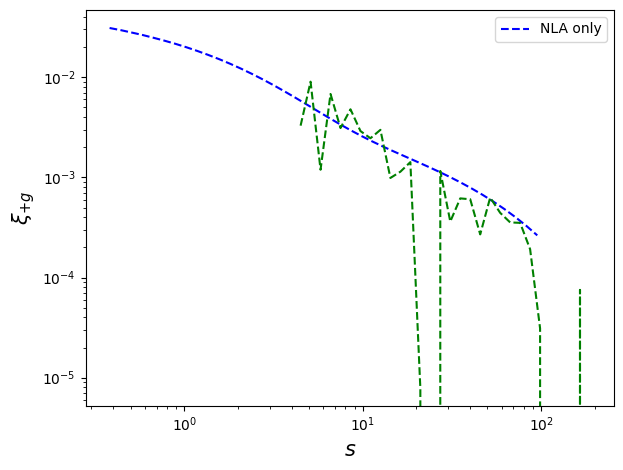

In [176]:


fig, ax = plt.subplots()

# ax.plot(thetas, xip_tot, label='Halo model', c='red')
ax.plot( np.pi/180 * thetas * da / 60, xip_NLA *3e2, label='NLA only', c='blue', ls='--')
ax.plot( s_cents , -xi_p_s , c='green', ls='--')
ax.set_ylabel(r'$\xi_{+g}$', fontsize=15)
ax.legend()

ax.set_xscale('log')
ax.set_xlabel(r'$s$', fontsize=15)

fig.tight_layout()
plt.yscale('log')

